<h2>Data Collection</h2>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN

<h1>Loading Dataset</h1>

In [2]:
data = pd.read_csv("StudentsPerformance.csv")
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:
data.shape

(1000, 8)

# Data Exploration

In [4]:
print("Data Shape:", data.shape)
print("Data Length:", len(data))
print("\n")
print("Data Types:\n", data.dtypes)
print("\n")
print("Data Description:\n", data.describe())
print("\n")
print("Data Information:\n", data.info())

Data Shape: (1000, 8)
Data Length: 1000


Data Types:
 gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object


Data Description:
        math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  -----

<h1>Data Cleaning</h1>

<h2>Checking Missing Values</h2>

In [5]:
missing_values = data.isnull().sum()
print(missing_values)

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


<h2>Checking and replacing zero values</h2>

In [6]:
zero_values = (data == 0).sum()
print("\nZero Values before cleaning:\n", zero_values)


Zero Values before cleaning:
 gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     1
reading score                  0
writing score                  0
dtype: int64


In [7]:
# Identify numerical columns to replace zero values
numerical_vars_with_zeros = ['math score', 'writing score', 'reading score']

# Replace zero values with NaN and then fill NaN with the column mean
for col in numerical_vars_with_zeros:
    data[col] = data[col].replace(0, np.NaN)
    data[col] = data[col].fillna(data[col].mean())
    
#Checking if the zero values are replaced
zero_values = (data == 0).sum()
print("\nZero Values after cleaning:\n", zero_values)


Zero Values after cleaning:
 gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


<h2>Identfying and Dropping Duplicate Values</h2>

In [8]:
# Identifying duplicate values
print("Duplicate values per column:", data.duplicated().sum())

Duplicate values per column: 0


In [9]:
# Handling Duplicate Values
data = data.drop_duplicates()
print("Dataset Shape After Removing Duplicates:", data.shape)

Dataset Shape After Removing Duplicates: (1000, 8)


<h2>Outlier Checking</h2>

In [10]:
# List of numerical columns
numerical_vars_with_zeros = ['math score', 'reading score', 'writing score']

# Filter the DataFrame to include only numerical columns
numerical_df = data[numerical_vars_with_zeros]

# Function to detect outliers using the IQR method
def detect_outliers(df):
    outliers = {}
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_condition = ((df[column] < lower_bound) | (df[column] > upper_bound))
        outliers[column] = df[column][outlier_condition]
    return outliers
    # Detect and print outliers before removal
print("\nOutliers before removal:")
outliers_before = detect_outliers(numerical_df)
for column, outliers in outliers_before.items():
    print(f"{column}: {outliers.index.tolist()}")


Outliers before removal:
math score: [17, 145, 338, 466, 787, 842, 980]
reading score: [59, 76, 211, 327, 596, 980]
writing score: [59, 76, 327, 596, 980]


In [11]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72.0,72,74
1,female,group C,some college,standard,completed,69.0,90,88
2,female,group B,master's degree,standard,none,90.0,95,93
3,male,group A,associate's degree,free/reduced,none,47.0,57,44
4,male,group C,some college,standard,none,76.0,78,75


# Identifying categorical columns

In [12]:
categorical_cols = data.select_dtypes(include=['object']).columns.tolist() 
print("Identified categorical columns:\n",categorical_cols)

Identified categorical columns:
 ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']


# Encoding categorical variables

In [13]:
from sklearn.preprocessing import LabelEncoder
# List of categorical columns
categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

# Dictionary to hold the label encoders for each column
label_encoders = {}

# Encoding categorical variables
for column in categorical_cols:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

In [14]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,72.0,72,74
1,0,2,4,1,0,69.0,90,88
2,0,1,3,1,1,90.0,95,93
3,1,0,0,0,1,47.0,57,44
4,1,2,4,1,1,76.0,78,75


<h2>Checking correlation among variables</h2>

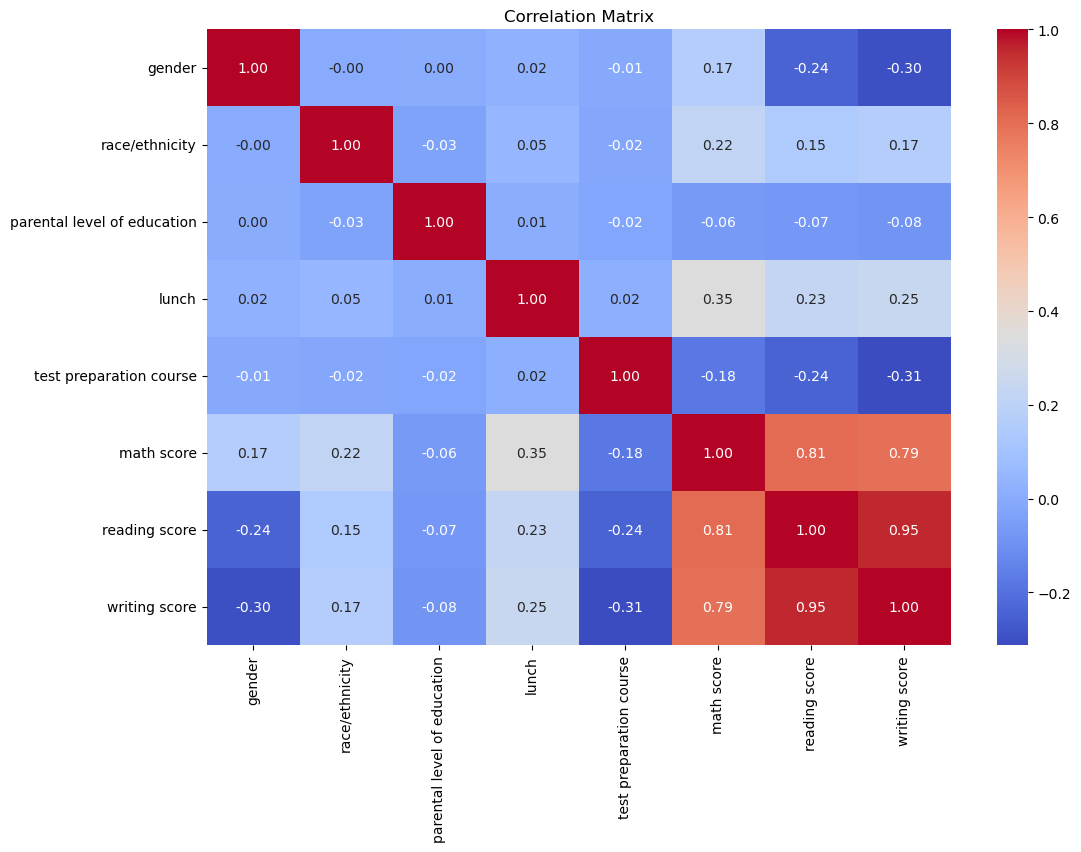

In [15]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix using Seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

<h2>Dropping Column to avoid Overfitting</h2>

In [16]:
#We have no columns to drop so we can skip this part and move on to EDA

<h1>Explanatory Data Analysis</h1>

<h2>Pairplot among numeric variables</h2>

C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=x, y=y, **kwargs)
C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1609: UserWarning: Ignoring `palette` because no `hue` variable

<Figure size 1500x1000 with 0 Axes>

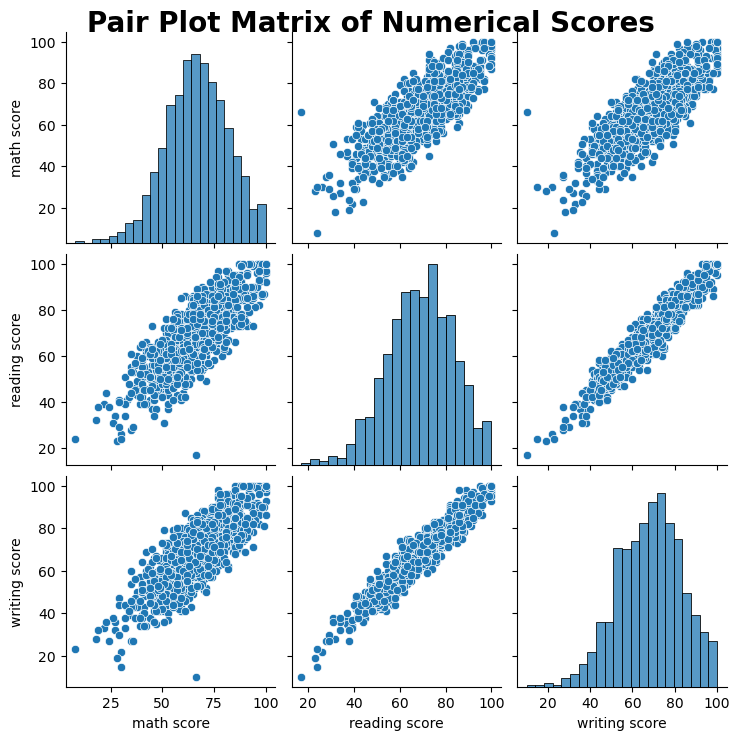

In [17]:
#Scatterplot for numerical columns
numerical_cols = ['math score', 'reading score', 'writing score']
plt.figure(figsize=(15,10))
pair_plot = sns.pairplot(data[numerical_cols], palette='magma')

# Adding titles and customizing the axes
pair_plot.fig.suptitle("Pair Plot Matrix of Numerical Scores", fontsize=20, fontweight='bold')
pair_plot.fig.subplots_adjust(top=0.95)  # Adjusting the title position
plt.show()

<h2>Visualization using Box Plot</h2>

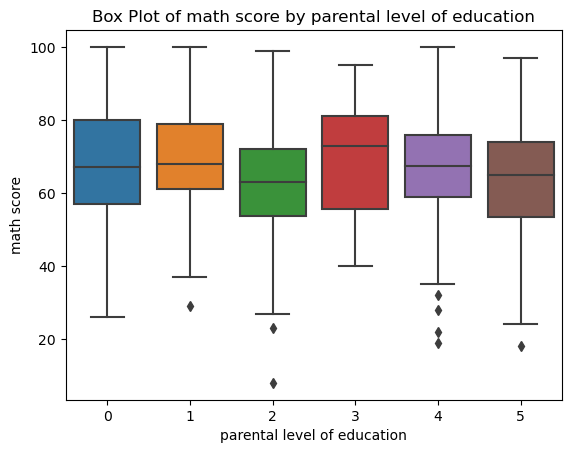

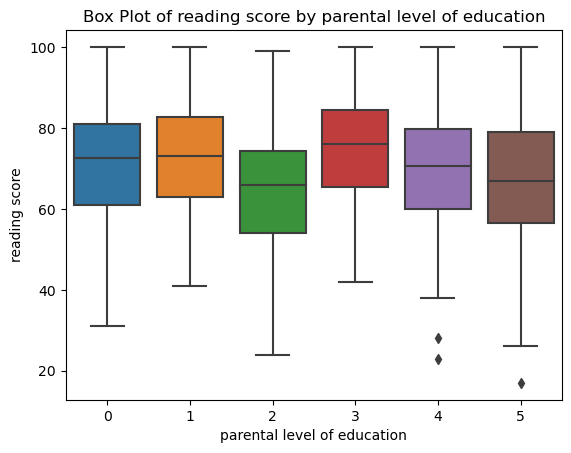

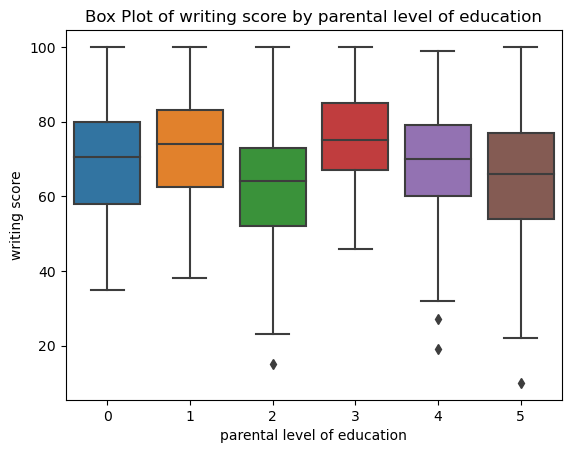

In [18]:
#Box plot of numerical variables against target variable
target = 'parental level of education'
for col in numerical_cols:
    sns.boxplot(x=target, y=col, data = data)
    plt.title(f'Box Plot of {col} by {target}')
    plt.xlabel('parental level of education')
    plt.ylabel(col)
    plt.show()

<h2>Visualization using Histogram</h2>

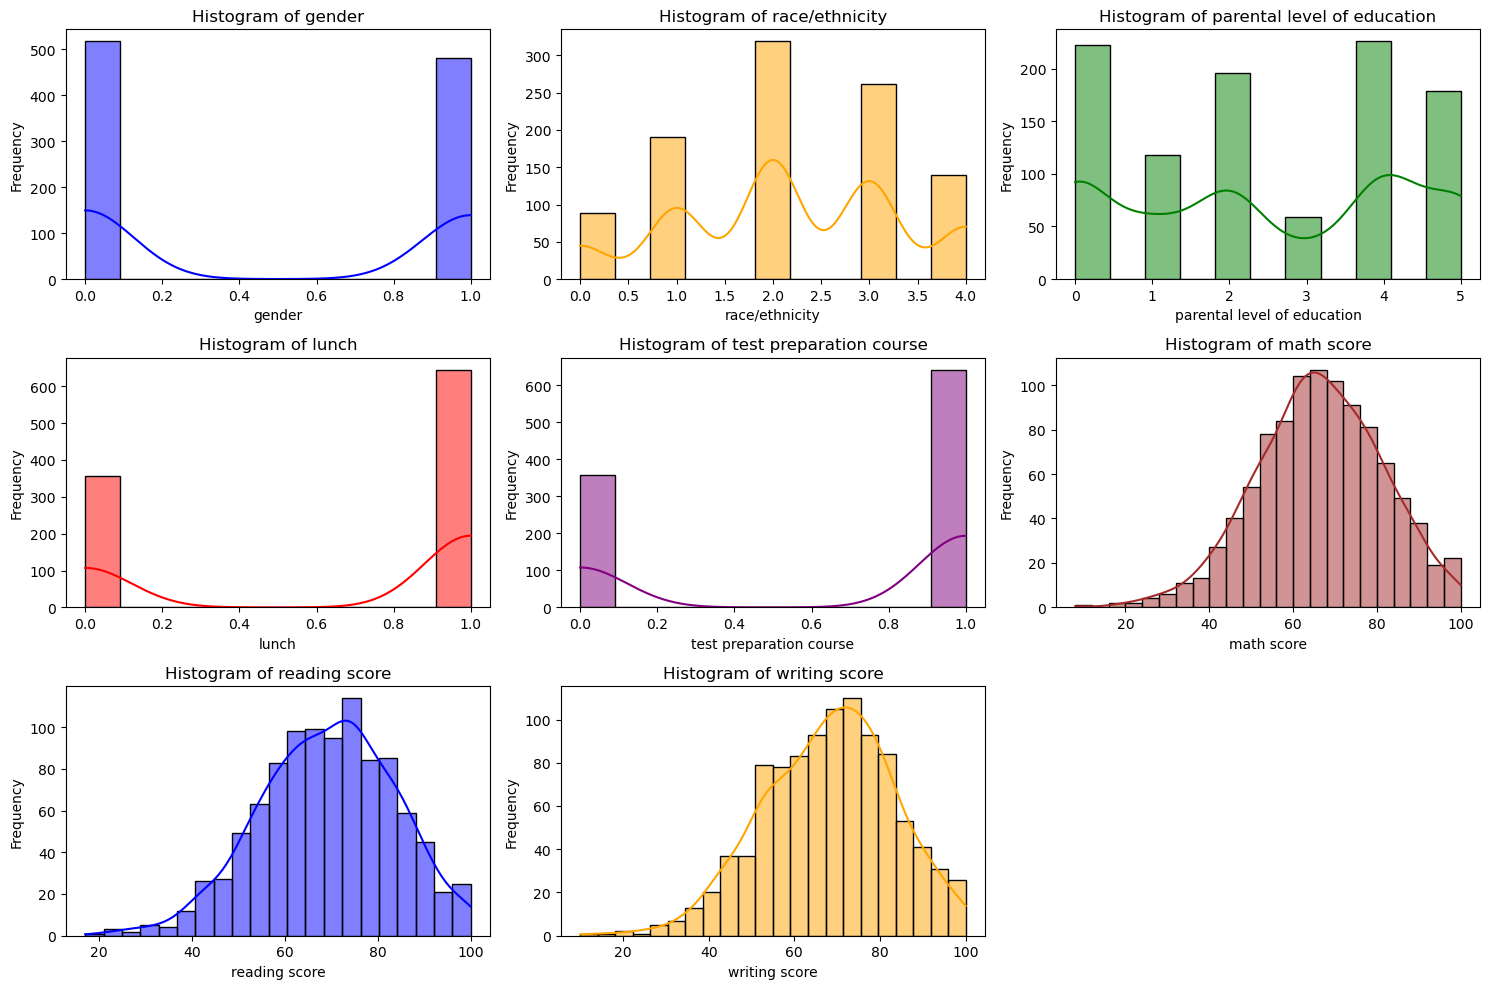

In [19]:
import math
# Set a custom color palette
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Calculate the number of rows and columns for the subplot grid
num_cols = len(data.columns)
num_rows = math.ceil(num_cols / 3)  # Adjust the number of columns as needed

# Plot histograms for each column
plt.figure(figsize=(15, 10))
for i, col in enumerate(data.columns):
    plt.subplot(num_rows, 3, i+1)  # Adjust the number of columns in the grid
    sns.histplot(data[col], kde=True, color=colors[i%len(colors)])  # Cycle through colors
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# Data Transformation

In [20]:
# Create a new column for the average score
data['average score'] = data[['math score', 'reading score', 'writing score']].mean(axis=1)

# Create a target variable with performance levels
bins = [0, 60, 80, 100]
labels = ['low', 'medium', 'high']
data['performance level'] = pd.cut(data['average score'], bins=bins, labels=labels, include_lowest=True)

In [21]:
# Create a target variable with performance levels
bins = [0, 60, 80, 100]
labels = ['low', 'medium', 'high']
data['performance level'] = pd.cut(data['average score'], bins=bins, labels=labels, include_lowest=True)

In [22]:
# Define features and target
X = data.drop(columns=['math score', 'reading score', 'writing score', 'average score', 'performance level'])
y = data['performance level']

# Balancing the dataset with the help of SMOTE

In [23]:
# Apply SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Convert back to DataFrame for consistency
data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='performance level')], axis=1)

<h2>Splitting Data</h2>

In [24]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [25]:
# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<h2>SVM Model</h2>


In [26]:
# Initializing and training the SVM model
svm_classifier = SVC(random_state=123)
svm_classifier.fit(X_train, y_train)

SVC(random_state=123)

In [27]:
# Making predictions
y_pred = svm_classifier.predict(X_test)

<h2>SVM Model Evaluation</h2>

In [28]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Printing metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8085106382978723
Precision: 0.8138835160111756
Recall: 0.8085106382978723
F1 Score: 0.8106191297680659

Classification Report:
              precision    recall  f1-score   support

        high       0.64      0.70      0.67        10
         low       0.89      0.84      0.86        19
      medium       0.83      0.83      0.83        18

    accuracy                           0.81        47
   macro avg       0.79      0.79      0.79        47
weighted avg       0.81      0.81      0.81        47



In [29]:
# Storing the metrics in a dictionary
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}
# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Score'])

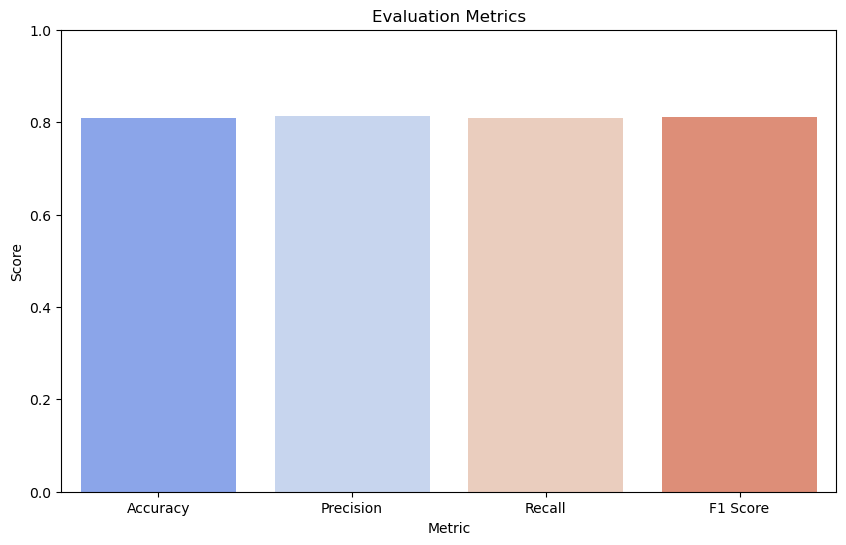

In [30]:
# Plot the metrics using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', data=metrics_df, palette='coolwarm')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.show()

Confusion Matrix:
[[ 7  0  3]
 [ 3 16  0]
 [ 1  2 15]]


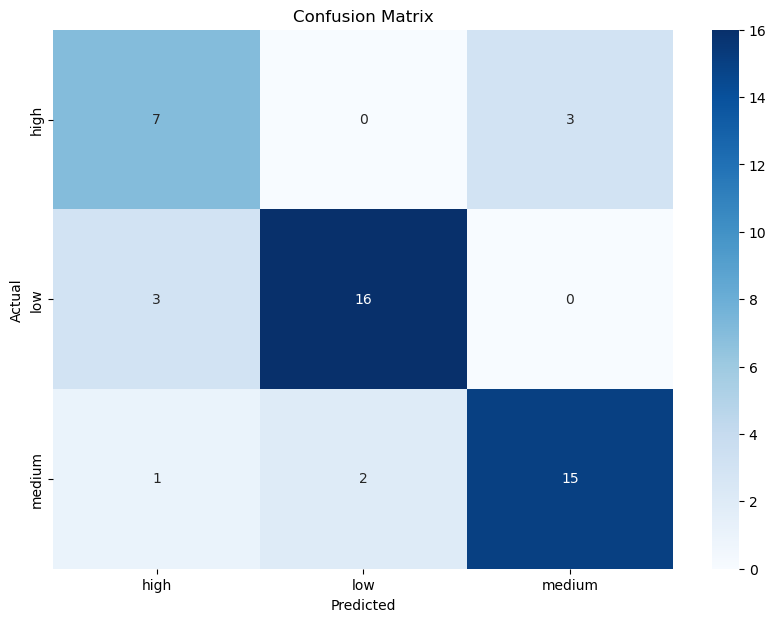

In [31]:
#Evaluating the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Plotting confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<h1>Random Forest</h1>

In [32]:
# Initializing the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators = 50, max_depth = 5, random_state=123)
# Training the model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, random_state=123)

In [33]:
# Making predictions
y_pred_rf = rf_classifier.predict(X_test)

In [34]:
# Evaluating the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

# Printing the metrics
print("Random Forest Model")
print("Accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print("F1 Score:", f1_rf)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Model
Accuracy: 0.9148936170212766
Precision: 0.922340425531915
Recall: 0.9148936170212766
F1 Score: 0.9117739954970704

Classification Report:
              precision    recall  f1-score   support

        high       1.00      0.70      0.82        10
         low       0.95      1.00      0.97        19
      medium       0.85      0.94      0.89        18

    accuracy                           0.91        47
   macro avg       0.93      0.88      0.90        47
weighted avg       0.92      0.91      0.91        47



In [35]:
# Storing the metrics in a dictionary
metrics_rf = {
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1 Score': f1_rf
}

# Convert the dictionary to a DataFrame
metrics_rf_df = pd.DataFrame(list(metrics_rf.items()), columns=['Metric', 'Score'])

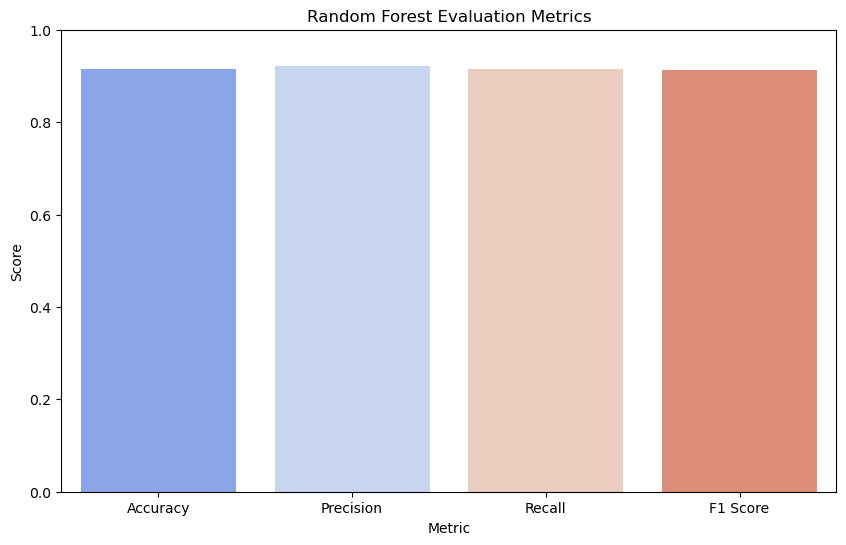

Confusion Matrix:
[[ 7  0  3]
 [ 0 19  0]
 [ 0  1 17]]


In [36]:
# Plot the metrics using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', data=metrics_rf_df, palette='coolwarm')
plt.title('Random Forest Evaluation Metrics')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.show()

# Evaluating the model with confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

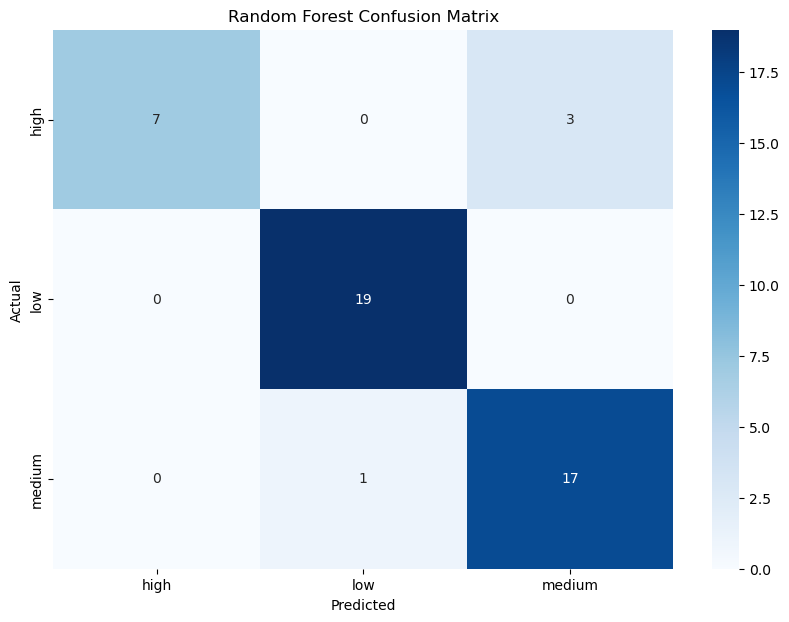

In [37]:
# Plotting confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Comparison of Models

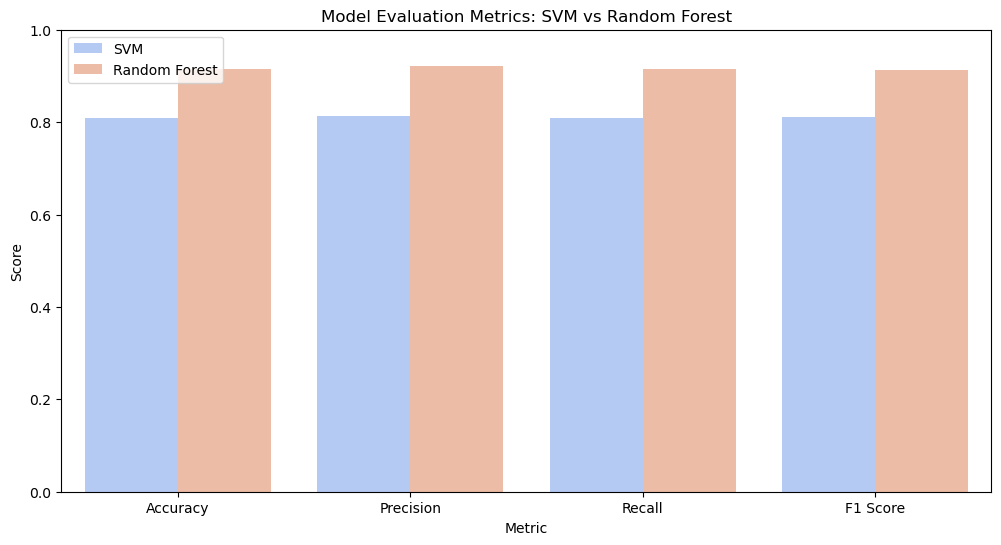

In [38]:
# Storing the metrics in dictionaries
metrics = {
    'Model': ['SVM', 'SVM', 'SVM', 'SVM',
              'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest'],
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score',
               'Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1,
              accuracy_rf, precision_rf, recall_rf, f1_rf]
}

metrics_df = pd.DataFrame(metrics)

# Plotting the metrics side by side
plt.figure(figsize=(12, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_df, palette='coolwarm')
plt.title('Model Evaluation Metrics: SVM vs Random Forest')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('Metric')
plt.legend(loc='upper left')
plt.show()

# Applying Deep Learning Models

In [39]:
#Importing necessary libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [40]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building the model

In [41]:
# Deep Learning Model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [42]:
# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Convert labels to one-hot encoding
y_train_oh = to_categorical(y_train_encoded, num_classes=3)
y_test_oh = to_categorical(y_test_encoded, num_classes=3)

# Reshape the target variable
y_train_oh = y_train_oh.reshape(-1, 3)
y_test_oh = y_test_oh.reshape(-1, 3)

In [43]:
#Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train_scaled, y_train_oh, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
5/5 [==============================] - 1s 48ms/step - loss: 1.1218 - accuracy: 0.2349 - val_loss: 1.1292 - val_accuracy: 0.1579
Epoch 2/50
5/5 [==============================] - 0s 10ms/step - loss: 1.0692 - accuracy: 0.4094 - val_loss: 1.0818 - val_accuracy: 0.3947
Epoch 3/50
5/5 [==============================] - 0s 10ms/step - loss: 1.0288 - accuracy: 0.5638 - val_loss: 1.0427 - val_accuracy: 0.5789
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 0.9950 - accuracy: 0.6644 - val_loss: 1.0061 - val_accuracy: 0.5789
Epoch 5/50
5/5 [==============================] - 0s 10ms/step - loss: 0.9635 - accuracy: 0.6577 - val_loss: 0.9687 - val_accuracy: 0.5526
Epoch 6/50
5/5 [==============================] - 0s 10ms/step - loss: 0.9301 - accuracy: 0.6376 - val_loss: 0.9334 - val_accuracy: 0.5526
Epoch 7/50
5/5 [==============================] - 0s 13ms/step - loss: 0.8999 - accuracy: 0.6376 - val_loss: 0.8980 - val_accuracy: 0.5526
Epoch 8/50
5/5 [===========

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Evaluating the model
y_pred_dl = model.predict(X_test_scaled)
y_pred_dl = np.argmax(y_pred_dl, axis=1)

# Convert y_test to numeric labels
le = LabelEncoder()
y_test_numeric = le.fit_transform(y_test)

accuracy_dl = accuracy_score(y_test_numeric, y_pred_dl)
conf_matrix_dl = confusion_matrix(y_test_numeric, y_pred_dl)
class_report_dl = classification_report(y_test_numeric, y_pred_dl)
print(f"Deep Learning Neural Network Accuracy: {accuracy_dl}")
print("Deep Learning Neural Network Confusion Matrix:")
print(conf_matrix_dl)
print("Deep Learning Neural Network Classification Report:")
print(class_report_dl)

2/2 [==============================] - 0s 3ms/step
Deep Learning Neural Network Accuracy: 0.8723404255319149
Deep Learning Neural Network Confusion Matrix:
[[ 7  0  3]
 [ 0 19  0]
 [ 1  2 15]]
Deep Learning Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.90      1.00      0.95        19
           2       0.83      0.83      0.83        18

    accuracy                           0.87        47
   macro avg       0.87      0.84      0.85        47
weighted avg       0.87      0.87      0.87        47



# Comparison of Model Performance

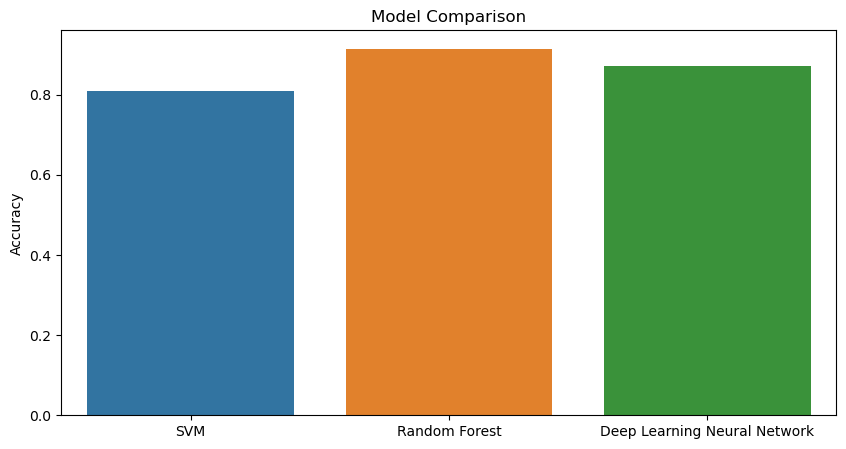

In [45]:
# Collecting model performance metrics
models = ['SVM', 'Random Forest', 'Deep Learning Neural Network']
accuracies = [accuracy, accuracy_rf, accuracy_dl]

# Plotting accuracy comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=accuracies)
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.show()